In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')



In [4]:

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * sig**2.))
def gaussian2D(x, y, mu, sig):
    [X, Y] = np.meshgrid(x, y)
    return np.dot(gaussian(x, mu[0], sig[0])[None].T, gaussian(y, mu[1], sig[1])[None])#np.exp(-((X - mu[0])**2 / (2 * sig[0]**2.) + (Y-mu[1])/ (2 * sig[1]**2.)) )


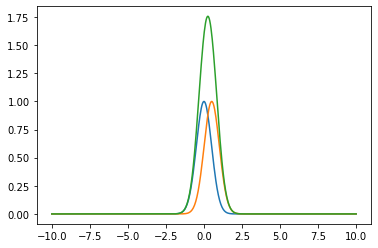

In [5]:
mu0 = 0
sigma = 0.5
mu1 = mu0+np.random.rand(1)*1.22*sigma

lim = 10
n = 500
x = np.linspace(-lim,lim, n)

amps = np.random.rand(2)*5

g0 = gaussian(x, 0, sigma)
g1 = gaussian(x, mu0, sigma)
g2 = gaussian(x, mu1, sigma)

plt.plot(x, g1)
plt.plot(x, g2)
plt.plot(x, g1+g2)
plt.show()

In [6]:
A = np.array([g1, g2]).T
B = np.dot(amps, A.T) 

B += np.random.randn(*B.shape)*np.max(B)/10.


In [7]:
X, *_ = np.linalg.lstsq(A, B, rcond = None)
Y, *_ = np.linalg.lstsq(g0[None].T, B, rcond = None)

In [8]:
print(X)
print(amps)

[3.33196789 3.39022083]
[3.64533502 3.08403903]


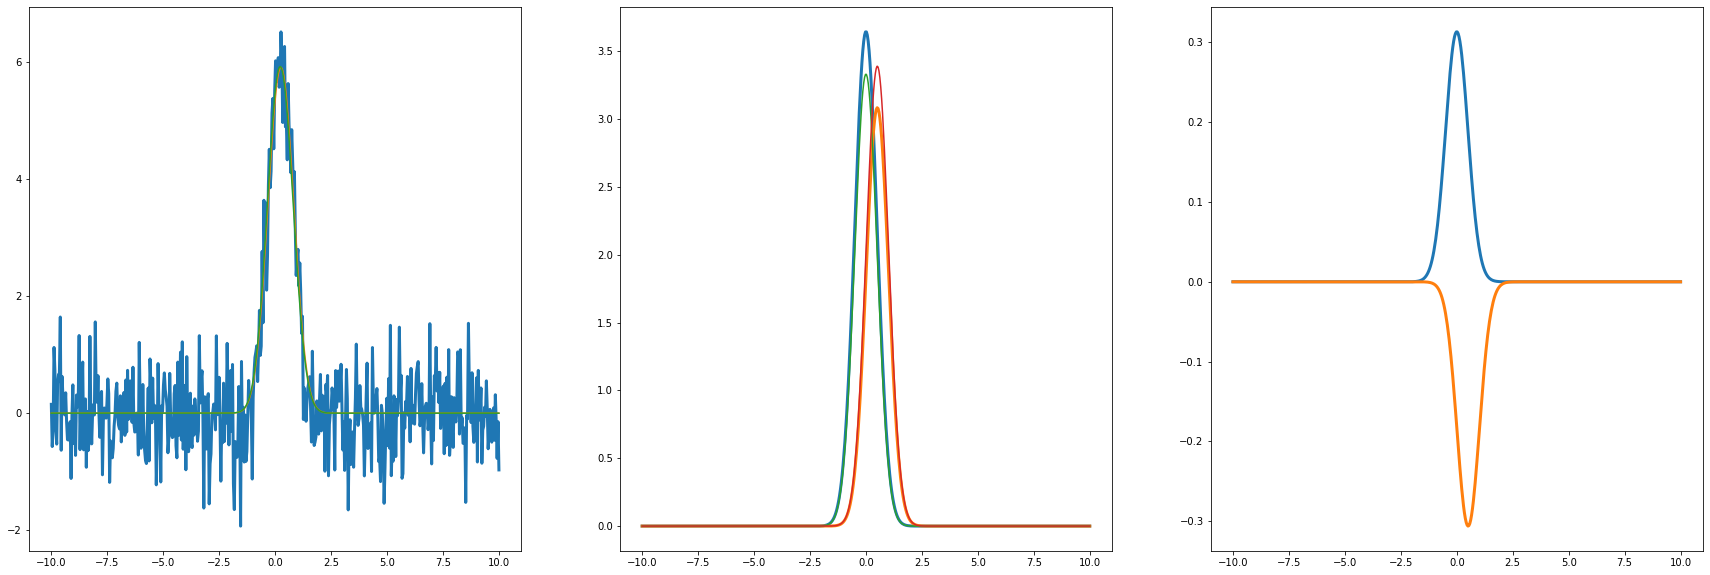

In [9]:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.plot(x, B, linewidth=3)
plt.plot(x, np.dot(X, A.T))
plt.plot(x, np.dot(amps, A.T))
plt.subplot(132)
plt.plot(x, amps[0]*g1, linewidth = 3)
plt.plot(x, amps[1]*g2, linewidth = 3)
plt.plot(x, X[0]*g1)
plt.plot(x, X[1]*g2)
plt.subplot(133)
plt.plot(x, amps[0]*g1-X[0]*g1, linewidth = 3)
plt.plot(x, amps[1]*g2-X[1]*g2, linewidth = 3)

plt.show()

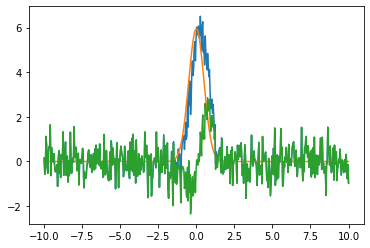

In [10]:
plt.plot(x, B)
plt.plot(x, Y*g0)
plt.plot(x, B-Y*g0)
plt.show()

In [11]:
def SN(t, m, t0, noise = 0):
    """a SN light curve explodes attime t0 withmagnitude m.
    The light curve is just a sum of 2 gaussians"""
    
    dt  = t[-1]-t[-2]
    g1 = gaussian(t, t0, np.max(t)/20)
    g2 = 2./3.*gaussian(t, t0+1.1*len(t)/(np.max(t)-np.min(t))*dt, np.max(t)/20)
    
    return m*(g1+g2)+noise*m*np.random.randn(len(t))

def lensedSN(t, t0, dtmax, mags, noise = 0):
    ''' Generates lensed SN light curves.
    t0: time of explosion
    dtmax: max time-delay
    mags: max value of each SN curve
    noise: noise level, fraction of the max.'''
    lc = 0
    dts = []
    for i,m in enumerate(mags):
        dt = np.min([i,1])*np.random.rand(1)*dtmax
        if dt>0:
            m*=1./np.max([1.,np.sqrt(dt)])
        lc += SN(t, m, t0+dt, noise)
        if i >0:
            dts.append(dt)
    return lc, np.array(dt)

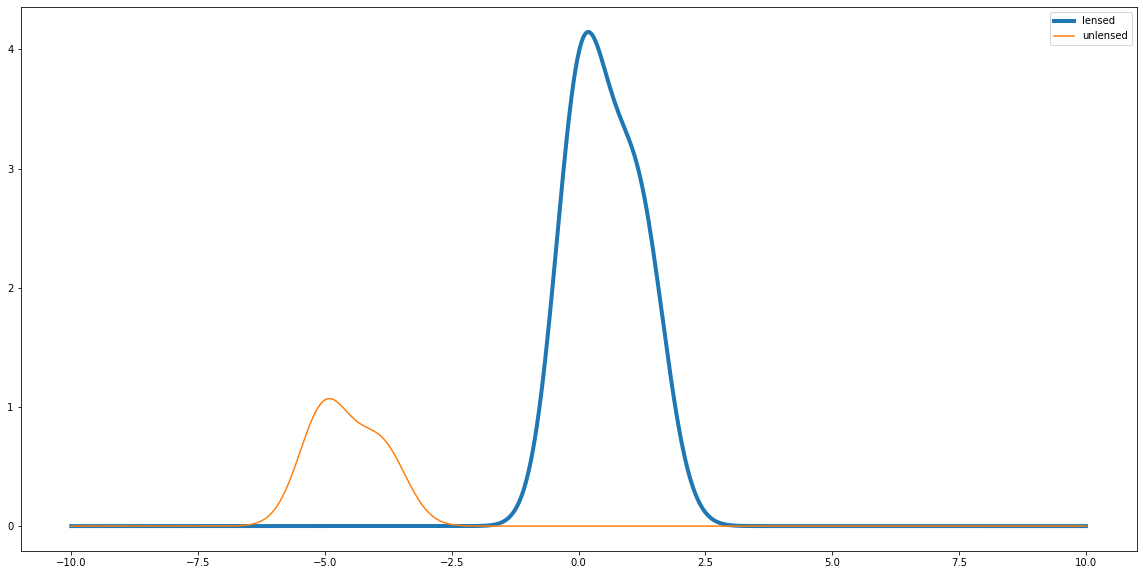

In [12]:

light_curve, dt = lensedSN(x, 0, 3., [3.,1.], noise = 0./10.)
light_curve_Unlensed = SN(x, 1., -5., noise = 0./10.)

plt.figure(figsize=(20,10))
plt.plot(x, light_curve, linewidth = 4, label = 'lensed')
plt.plot(x, light_curve_Unlensed , label='unlensed')
plt.legend()
plt.show()


In [20]:
curves = {'curves': [], 'dts': [], 't0s':[], 'lensed':[], 'sampling': []}
N = 5000
for i in range(N):
    
    noise = 0./10.
    #x = np.sort(np.random.uniform(-lim, lim, 1000))
    mag = np.random.rand(2)
    pos = np.random.uniform(-lim+2, lim-2, 2)

    dtmax = np.random.rand(1)*(lim-pos[1]-2)

    SN_curve = SN(x, mag[0], pos[0], noise = noise)
    
    curves['curves'].append(SN_curve)
    curves['dts'].append(0.)
    curves['t0s'].append(pos[0])
    curves['lensed'].append(False)
    curves['sampling'].append(x)
    
    #x = np.sort(np.random.uniform(-lim, lim, 1000))
    lensed, dt = lensedSN(x, pos[1], dtmax, [mag[1], mag[1]*np.random.rand(1)[0]] , noise = noise)
    
    curves['curves'].append(lensed)
    curves['dts'].append(*dt)
    curves['t0s'].append(pos[1])
    curves['lensed'].append(True)
    curves['sampling'].append(x)
    
curves['curves']=np.array(curves['curves'])
curves['dts']=np.array(curves['dts'])
curves['t0s']=np.array(curves['t0s'])
curves['lensed']=np.array(curves['lensed'])
curves['sampling']=np.array(curves['sampling'])


(10000, 500)


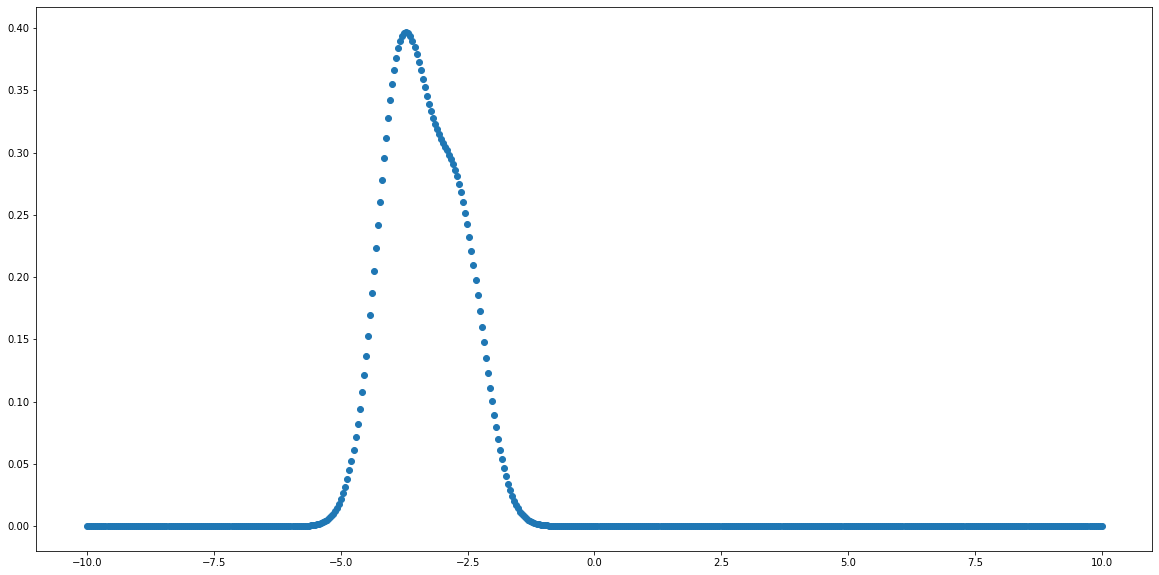

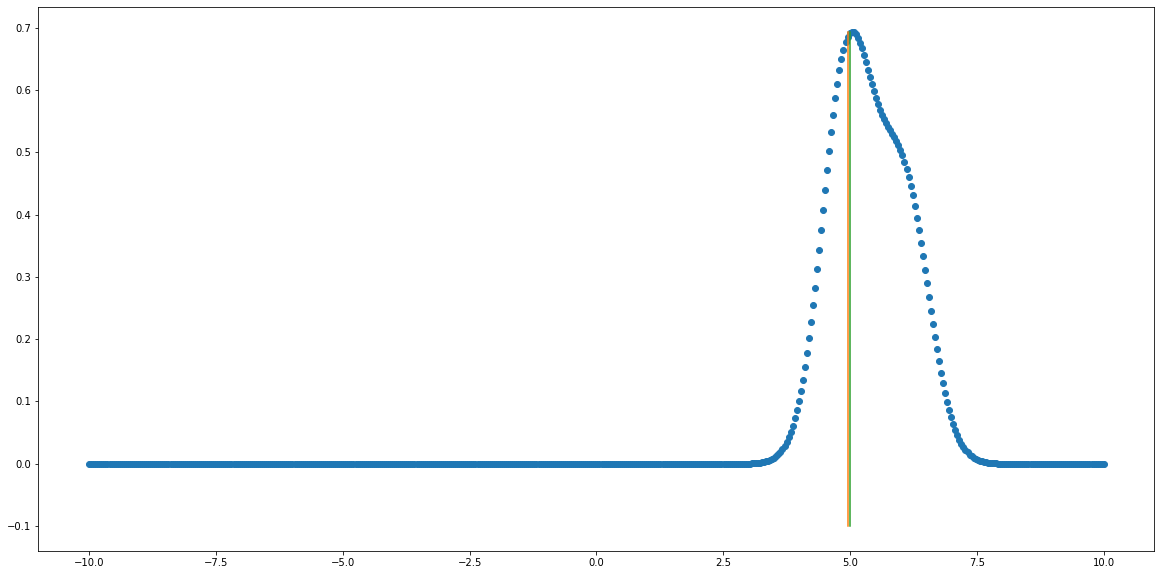

In [21]:
print(curves['sampling'].shape)
plt.figure(figsize=(20,10))
plt.plot(np.array(curves['sampling']).T[:,0], np.array(curves['curves']).T[:,0], 'o')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(np.array(curves['sampling']).T[:,1], np.array(curves['curves']).T[:,1], 'o')
plt.plot([curves['t0s'][1], curves['t0s'][1]], [-0.1,np.max(np.array(curves['curves']).T[:,1])])
plt.plot([curves['t0s'][1]+curves['dts'][1], curves['t0s'][1]+curves['dts'][1]], [-0.1,np.max(np.array(curves['curves']).T[:,1])])
plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer

rf  = RandomForestRegressor()
gb  = GradientBoostingRegressor()

parameters = {
    'n_estimators': [20, 30,50],
    'max_depth': [10, 20, 30]
}

def loss(prediction, truth):
    
    loss = np.sqrt(np.sum(((truth)-(prediction))**2)/len(truth))
    return -loss

#data = pd.DataFrame(curves)

x_train = curves['curves'][:int(N)]
y_train = curves['dts'][:int(N)]


#score = make_scorer(loss, greater_is_better=False)
#cv = GridSearchCV(rf, parameters, cv=5, scoring=score)
#cv.fit(x_train, y_train)

In [14]:

results = pd.DataFrame(cv.cv_results_)[['params', 'mean_test_score']]
print(f"Best result {np.min(results['mean_test_score'])}")
results

NameError: name 'cv' is not defined

In [15]:
gb  = GradientBoostingRegressor(n_estimators = 20, max_depth=10)
rf = RandomForestRegressor(n_estimators = 100, max_depth=20)

x_test = np.array(curves['curves'])[int(N):]
y_test = np.array(curves['dts'])[int(N):]

#res = gb.fit(x_test, y_test)

In [ ]:
plt.figure(figsize=(50,10))
plt.plot(res.predict(x_test))
plt.plot(y_test)
plt.show()
plt.plot(res.predict(x_test)-y_test)
plt.show()

predictions = res.predict(x_test)

plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(predictions[y_test==0])
plt.ylim([-0.1, np.max(predictions)])
plt.subplot(122)
plt.plot(predictions[y_test!=0])

In [ ]:
plt.figure(figsize=(30,20))
plt.plot(predictions[y_test!=0])
plt.plot(predictions[y_test==0])
plt.ylim([-0.1, np.max(predictions)-5])


In [49]:

def make_model(input_shape):
    num_classes = len(np.unique(y_train))
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=256, padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.001))(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=8, strides=4, padding="valid")(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=16, padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.001))(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=8, strides=2, padding="valid")(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=8, padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.001))(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.MaxPooling1D(pool_size=4, strides=1, padding="valid")(conv3)
    
    conv4 = keras.layers.Conv1D(filters=128, kernel_size=4, padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.001))(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.MaxPooling1D(pool_size=4, strides=1, padding="valid")(conv4)

    gap = keras.layers.GlobalAveragePooling1D()(conv4)

    output_layer = keras.layers.ReLU(threshold=0.)(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


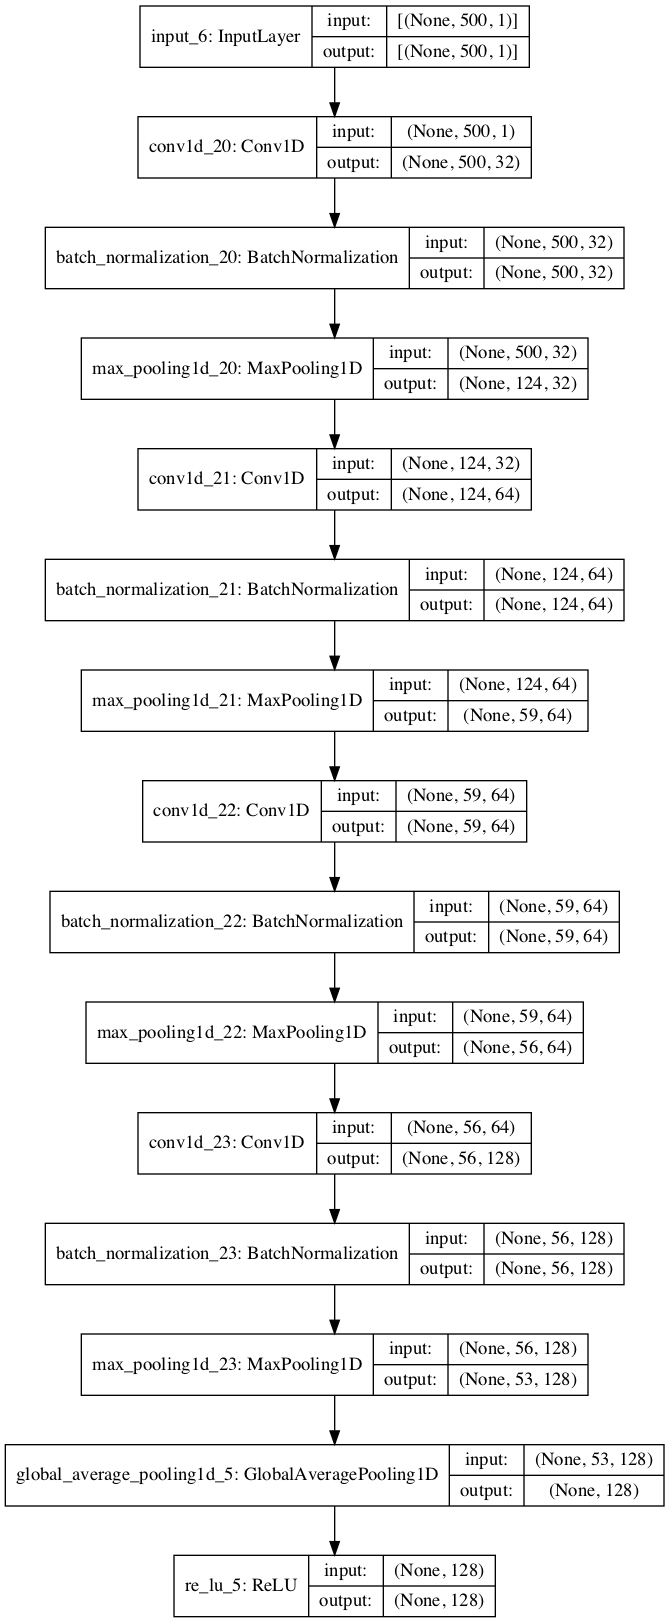

In [50]:

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [51]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss", loss=keras.losses.MeanSquaredError()
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001, loss=keras.losses.MeanSquaredError()
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam", loss=keras.losses.MeanSquaredError()
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
125/125 [==============================] - 7s 48ms/step - loss: 3.7523 - val_loss: 3.7926
Epoch 2/500
125/125 [==============================] - 6s 46ms/step - loss: 3.6748 - val_loss: 4.1901
Epoch 3/500
125/125 [==============================] - 6s 46ms/step - loss: 2.9277 - val_loss: 5.5820
Epoch 4/500
125/125 [==============================] - 6s 47ms/step - loss: 3.0923 - val_loss: 3.2543
Epoch 5/500
125/125 [==============================] - 6s 47ms/step - loss: 2.9893 - val_loss: 3.7996
Epoch 6/500
125/125 [==============================] - 6s 49ms/step - loss: 2.8220 - val_loss: 3.0574
Epoch 7/500
125/125 [==============================] - 6s 49ms/step - loss: 2.6300 - val_loss: 3.1399
Epoch 8/500
125/125 [==============================] - 6s 50ms/step - loss: 2.8266 - val_loss: 3.1089
Epoch 9/500
125/125 [==============================] - 6s 52ms/step - loss: 2.5805 - val_loss: 3.2112
Epoch 10/500
125/125 [==============================] - 7s 54ms/step - loss: 2.254

In [44]:
model = keras.models.load_model("best_model.h5")
??model
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape, y_test.shape)
test_loss = model.evaluate(x_test, y_test)

print("Test loss", test_loss)


(5000, 500) (5000,)
157/157 [==============================] - 1s 7ms/step - loss: 3.1043
Test loss 3.1043248176574707


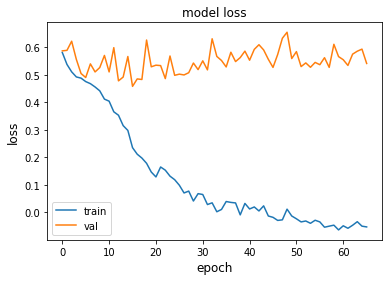

In [45]:
metric = "loss"
plt.figure()
plt.plot(np.log10(history.history[metric]))
plt.plot(np.log10(history.history["val_" + metric]))
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


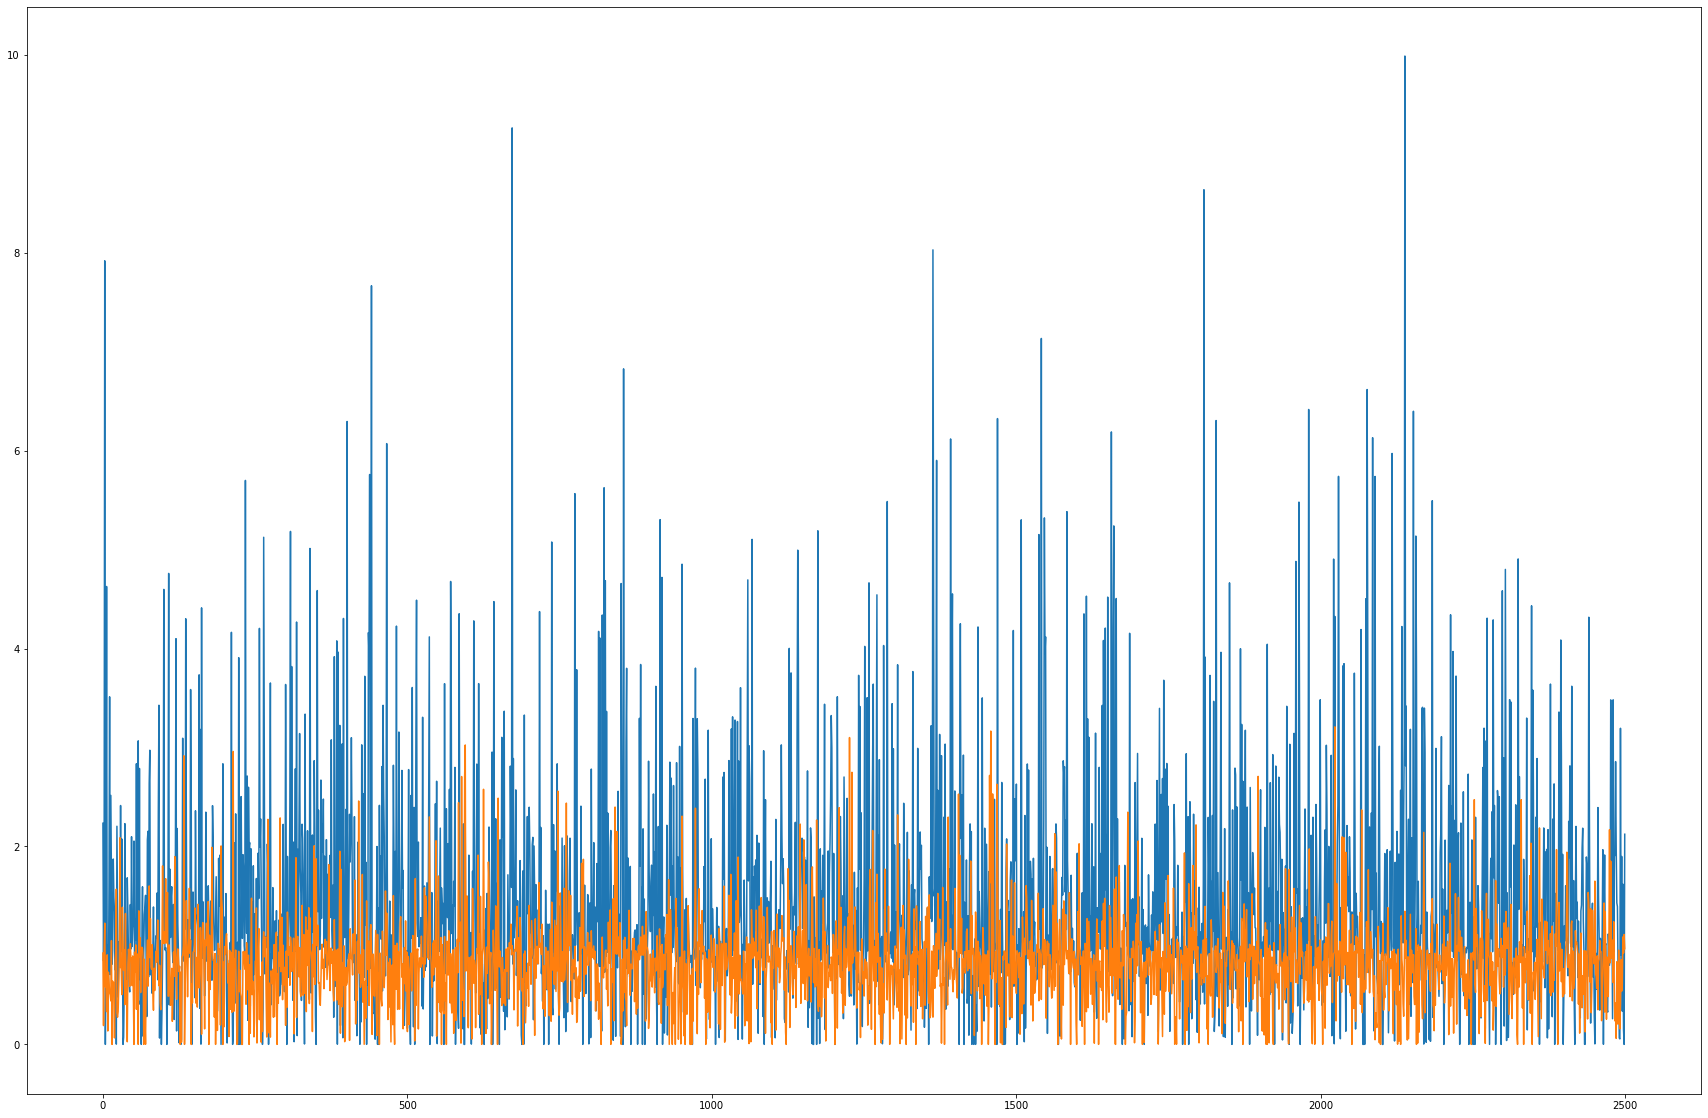

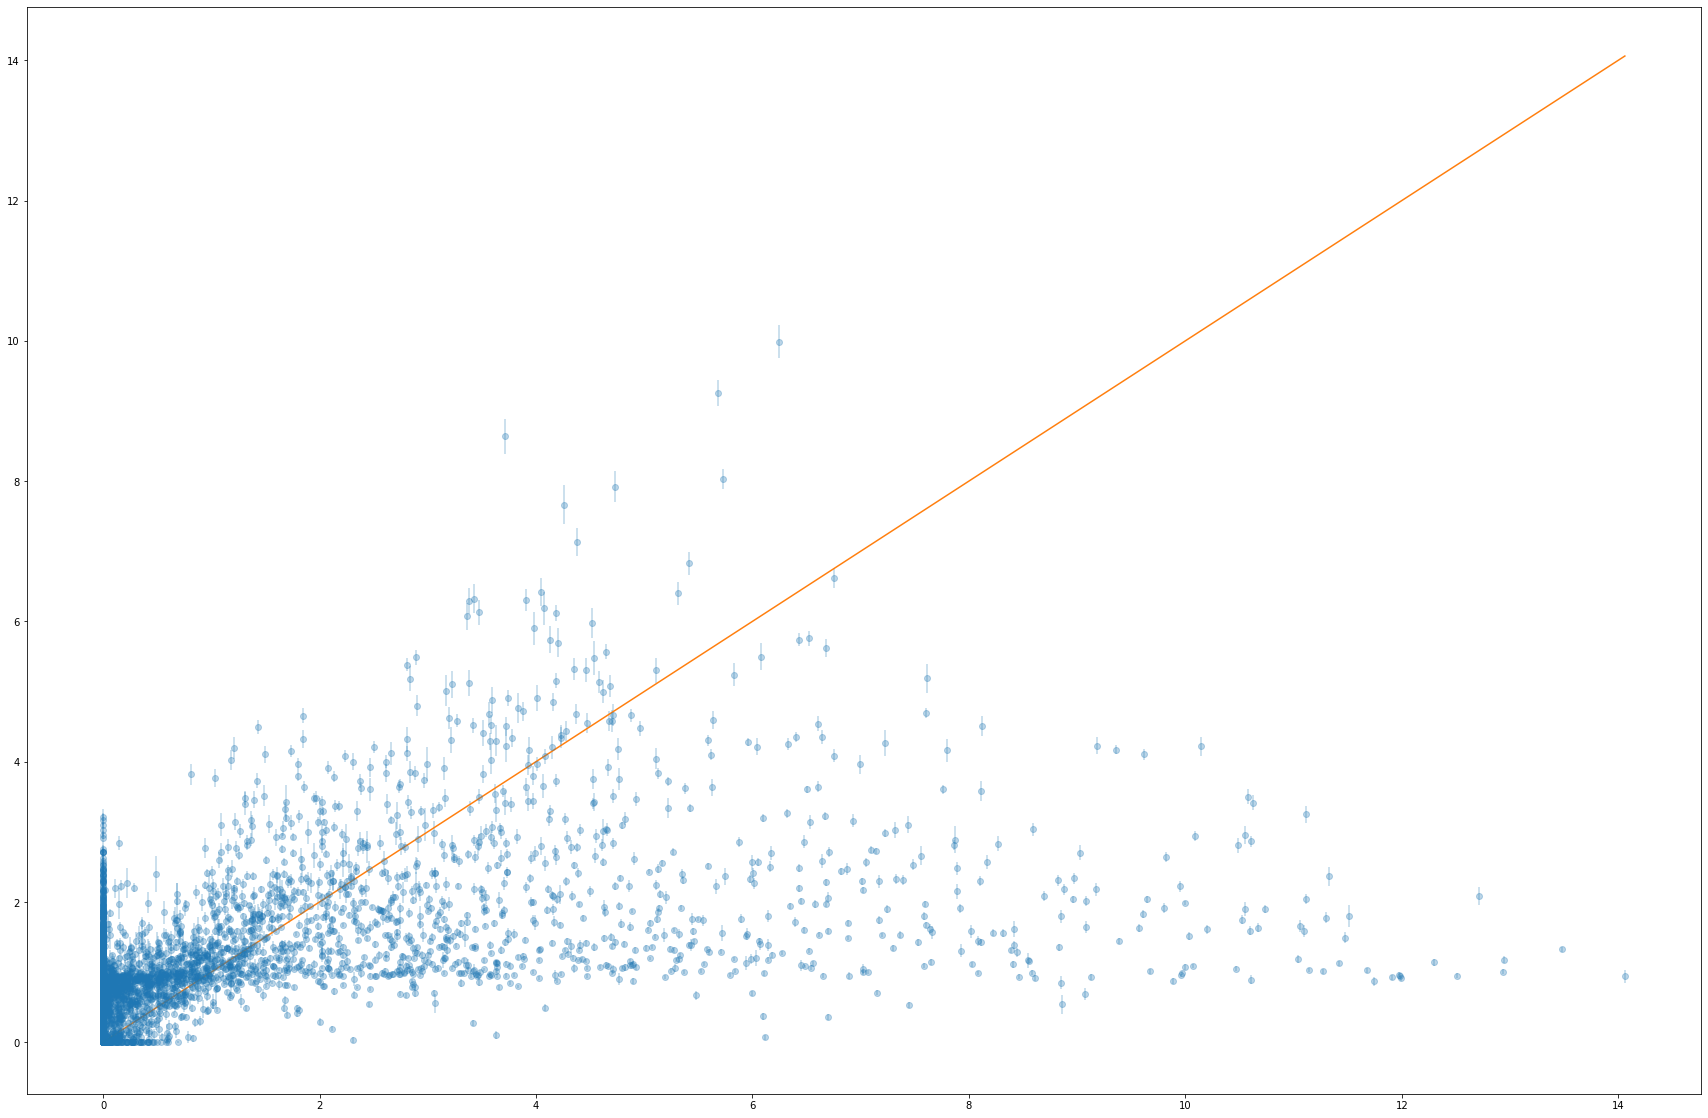

In [46]:
pred = model.predict(x_test)

mean_pred = np.mean(pred, axis = -1)
std_pred = np.std(pred, axis = -1)

plt.figure(figsize=(30,20))
plt.plot(mean_pred[y_test!=0])
plt.plot(mean_pred[y_test==0])
plt.show()

plt.figure(figsize=(30,20))
plt.errorbar(y_test, mean_pred, yerr=std_pred, fmt='o', alpha = 0.3)
plt.plot([0,np.max(y_test)], [0,np.max(y_test)])
plt.show()

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()
print(type(y_train))

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape, y_train.shape)
print(len(np.unique(y_train)))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

print(x_train.shape, y_train.shape)
model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
epochs = 500
batch_size = 32

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

print(y_train.shape, x_train.shape)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)
